### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
import torchvision.transforms as T
import os
from torch.optim.lr_scheduler import _LRScheduler
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2 as cv
from skimage.measure import label
from IPython.display import clear_output

from models.vae import VAE
from models.base import Decoder, Encoder
from models.rhvae import RHVAE
from models.hvae import HVAE
from models.vqvae import VQVAE

print('imported')

imported


### Constants

In [2]:
np.random.seed(42)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

DATA_DIR = './data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

WEIGHTS_DIR = './weights'
if not os.path.exists(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)

IMG_SIZE = (128, 128)
NUM_CHANNELS = 1
BATCH_SIZE = 64
EPOCHS = 5000
LEARNING_RATE = 0.001
LATENT_DIM = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device: {} ({})'.format(device, torch.cuda.get_device_name(device)))

Current device: cuda (NVIDIA RTX A6000)


### Load data

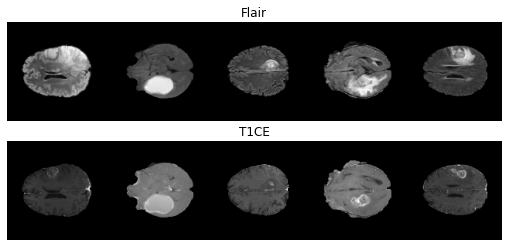

Number of train samples: 300
Number of test samples: 50
Image size: torch.Size([128, 128])
Total shape: torch.Size([300, 1, 128, 128])


In [3]:
# loading brats dataset
train, test = np.load('./data/brats_data.npz'), np.load('./data/brats_data_test.npz')
train_flair, train_t1ce, test_flair, test_t1ce = train['flair'], train['t1ce'], test['flair'], test['t1ce']
train_mask, test_mask = train['mask'], test['mask']

# turning the data into tensors
train_flair = torch.tensor(train_flair, dtype=torch.float32)
train_t1ce = torch.tensor(train_t1ce, dtype=torch.float32)
train_mask = torch.tensor(train_mask, dtype=torch.float32)
test_flair = torch.tensor(test_flair, dtype=torch.float32)
test_t1ce = torch.tensor(test_t1ce, dtype=torch.float32)
test_mask = torch.tensor(test_mask, dtype=torch.float32)

# resizing images
train_flair = T.functional.resize(train_flair, IMG_SIZE)
test_flair = T.functional.resize(test_flair, IMG_SIZE)
train_t1ce = T.functional.resize(train_t1ce, IMG_SIZE)
test_t1ce = T.functional.resize(test_t1ce, IMG_SIZE)
train_mask = T.functional.resize(train_mask, IMG_SIZE)
test_mask = T.functional.resize(test_mask, IMG_SIZE)

train_mask[train_mask > 0] = 1
test_mask[test_mask > 0] = 1

# preprocessing
n_max_train_flair = [train_flair[i].max() for i in range(train_flair.shape[0])]
n_max_train_t1ce = [train_t1ce[i].max() for i in range(train_t1ce.shape[0])]
n_max_test_flair = [test_flair[i].max() for i in range(test_flair.shape[0])]
n_max_test_t1ce = [test_t1ce[i].max() for i in range(test_t1ce.shape[0])]

for idx in range(0, train_flair.shape[0]):
    train_flair[idx] = (train_flair[idx] / n_max_train_flair[idx])
    train_t1ce[idx] = (train_t1ce[idx] / n_max_train_t1ce[idx])

for idx in range(0, test_flair.shape[0]):
    test_flair[idx] = (test_flair[idx] / n_max_test_flair[idx])
    test_t1ce[idx] = (test_t1ce[idx] / n_max_test_t1ce[idx])

class BraTSDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

# visualizing a sample
n_to_visualize = 5
rand_idx = np.random.randint(0, test_flair.shape[0], n_to_visualize)

plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.imshow(np.hstack([test_flair[idx, 0] for idx in rand_idx]), cmap='gray')
plt.title('Flair')
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(np.hstack([test_t1ce[idx, 0] for idx in rand_idx]), cmap='gray')
plt.title('T1CE')
plt.axis('off')

plt.show()

print('Number of train samples: {}'.format(train_flair.shape[0]))
print('Number of test samples: {}'.format(test_flair.shape[0]))
print('Image size: {}'.format(train_flair.shape[2:]))
print('Total shape: {}'.format(train_flair.shape))

In [12]:
class PolyScheduler(_LRScheduler):
    def __init__(self, optimizer, base_lr, max_steps, warmup_steps, last_epoch=-1):
        self.base_lr = base_lr
        self.warmup_lr_init = 0.0001
        self.max_steps: int = max_steps
        self.warmup_steps: int = warmup_steps
        self.power = 2
        super(PolyScheduler, self).__init__(optimizer, -1, False)
        self.last_epoch = last_epoch

    def get_warmup_lr(self):
        alpha = float(self.last_epoch) / float(self.warmup_steps)
        return [self.base_lr * alpha for _ in self.optimizer.param_groups]

    def get_lr(self):
        if self.last_epoch == -1:
            return [self.warmup_lr_init for _ in self.optimizer.param_groups]
        if self.last_epoch < self.warmup_steps:
            return self.get_warmup_lr()
        else:
            alpha = pow(
                1
                - float(self.last_epoch - self.warmup_steps)
                / float(self.max_steps - self.warmup_steps),
                self.power,
            )
            return [self.base_lr * alpha for _ in self.optimizer.param_groups]

def plot(x, title, n_samples=5, figsize=(10, 2)):    
    plt.figure(figsize=figsize)
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(x[i] if n_samples > 1 else x, cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

### Architecture

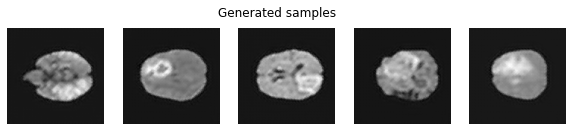

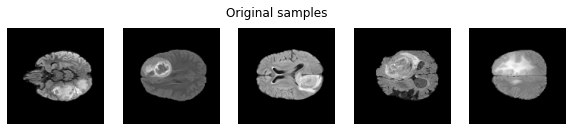

Epoch:  4952/5000 - Phase: train  - Total loss: 0.0016: 100%|██████████| 5/5 [00:00<00:00, 10.49it/s]
Epoch:  4953/5000 - Phase: train  - Total loss: 0.0016: 100%|██████████| 5/5 [00:00<00:00, 10.81it/s]
Epoch:  4954/5000 - Phase: train  - Total loss: 0.0016: 100%|██████████| 5/5 [00:00<00:00, 10.62it/s]
Epoch:  4955/5000 - Phase: train  - Total loss: 0.0016: 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]
Epoch:  4956/5000 - Phase: train  - Total loss: 0.0016: 100%|██████████| 5/5 [00:00<00:00, 10.86it/s]
Epoch:  4957/5000 - Phase: train  - Total loss: 0.0016: 100%|██████████| 5/5 [00:00<00:00, 10.67it/s]
Epoch:  4958/5000 - Phase: train  - Total loss: 0.0016: 100%|██████████| 5/5 [00:00<00:00, 10.28it/s]
Epoch:  4959/5000 - Phase: train  - Total loss: 0.0016: 100%|██████████| 5/5 [00:00<00:00, 10.46it/s]
Epoch:  4960/5000 - Phase: train  - Total loss: 0.0016: 100%|██████████| 5/5 [00:00<00:00,  9.96it/s]
Epoch:  4961/5000 - Phase: train  - Total loss: 0.0016: 100%|██████████| 5/5 [00:0

Training over


: 

In [18]:
verbose = True

model = VQVAE(in_channel=1, channel=256, n_res_block=2, n_res_channel=32, n_embed=512, embed_dim=64, decay=0.99).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
criterion = nn.MSELoss()
latent_loss_weight = 0.25

# data loader
train_loader = torch.utils.data.DataLoader(BraTSDataset(train_flair, train_flair), batch_size=BATCH_SIZE, shuffle=True)

# scheduler
scheduler = PolyScheduler(optimizer, LEARNING_RATE, EPOCHS * len(train_loader), warmup_steps=len(train_loader), last_epoch=-1)

train_loss_history, test_loss_history = [], []

for epoch in range(EPOCHS):
    for phase in ['train']:# , 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = test_loader

        running_loss = 0.0

        progress = None
        if verbose: progress = tqdm(dataloader, position=0, leave=True)
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                recon, latent_loss = model(x)
                recon_loss = criterion(recon, x)
                loss = recon_loss + latent_loss_weight * latent_loss
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    scheduler.step()

            running_loss += loss.item()
            if verbose:
                with torch.no_grad():
                    progress.update(1)
                    progress.set_description(
                        'Epoch: {:5}/{} - Phase: {:6} - Total loss: {:.4f}'
                        .format(epoch + 1, EPOCHS, phase, running_loss / (i + 1))
                    )

        epoch_loss = running_loss / dataloader.__len__()
        
        if phase == 'train':
            train_loss_history.append(epoch_loss)
        else:
            test_loss_history.append(epoch_loss)

        if verbose: progress.close()
        del progress

        model.eval()
        if verbose and (epoch) % 50 == 0:
            clear_output(wait=True)
            n_samples = 5
            with torch.no_grad():
                random_idx = np.random.randint(0, len(train_flair), n_samples)
                sample = train_flair[random_idx]
                recon = model(sample.to(device))
                plot(recon[0].detach().cpu().squeeze(1), 'Generated samples', n_samples=n_samples, figsize=(10, 2))
                plot(sample.squeeze(1), 'Original samples', n_samples=n_samples, figsize=(10, 2))

print('Training over')